Using large-scale datasets

In [48]:
import os
from datasets import load_dataset, load_from_disk
import json

dataset_maps = {
    "zeqianli/HowToStep": {
        "path": "./static/datasets/howtostep",
        "split": "train",
    },
    "ajibawa-2023/WikiHow": {
        "path": "./static/datasets/wikihow",
        "split": "train",
    },
    "ht-step": {
        "path": "./static/datasets/ht-step",
        "split": "train",
    }
}

def setup_ht_step(dataset_info):
    """
    return a dictionary --> 
    activity: {
        variation_index,
        variation,
        steps: [{
            step_id,
            step_index,
            headline,
            paragraph,
        }]
        videos: [{
            video_id,
            variation,
            segments: [{
                segment,
                partial,
                step_id,
            }]
        }]
    }
    """

    path = dataset_info["path"]
    split = dataset_info["split"]
    # video_splits = json.load(open(path + "/video_splits.json"))
    taxonomy = pd.read_csv(dataset_info["path"] + "/taxonomy.csv")
    ants = json.load(open(dataset_info["path"] + "/annotations.json"))
    # -- get the annotations for this split
    ants = {kk:vv for kk,vv in ants.items() if vv['subset'] == split}

    step2info = {vv['global_step_index']: vv for vv in taxonomy.to_dict(orient='records')}
    act2vars2steps = {}
    for kk, vv in step2info.items():
        activity = vv["activity"]
        variation = vv["variation"]
        if activity not in act2vars2steps:
            act2vars2steps[activity] = {}
        if variation not in act2vars2steps[activity]:
            act2vars2steps[activity][variation] = []
        act2vars2steps[activity][variation].append(vv)
    for act, vv in act2vars2steps.items():
        vars_list = []
        for var, steps in vv.items():
            vars_list.append({
                "variation": var,
                "steps": sorted(steps, key=lambda x: -x["step_index"])
            })

    act_list = [{
        "task": act,
        "variations": vv,
    } for act, vv in act2vars2steps.items()]
    act_list = sorted(act_list, key=lambda x: -len(x["variations"]))

    for kk, vv in ants.items():
        activity = vv["activity"]
        variation = vv["variation"]
        for seg in vv["annotations"]:
            cur_step_info = step2info[seg["id"]]
            assert cur_step_info["global_step_index"] == seg["id"] and cur_step_info["activity"] == activity and cur_step_info["variation"] == variation

    return {
        "annotations": ants,
        "step2info": step2info,
        "activity_info": act_list,
    }

def get_dataset(dataset_id):
    dataset = None
    ### check if dataset is already downloaded
    if dataset_id in dataset_maps:
        if dataset_id == "ht-step":
            return setup_ht_step(dataset_maps[dataset_id])
        path = dataset_maps[dataset_id]["path"]
        split = dataset_maps[dataset_id]["split"]
        if os.path.exists(path):
            print("Dataset already downloaded")
            dataset = load_from_disk(path)
        else:
            print("Dataset not downloaded yet")
            dataset = load_dataset(dataset_id, split=split)
            dataset.save_to_disk(path)
    else:
        print("Dataset not found")
    return dataset

### ds to pandas
import pandas as pd

# cur_dataset = "zeqianli/HowToStep"
# cur_dataset = "ajibawa-2023/WikiHow"
cur_dataset = "ht-step"
ds = get_dataset(cur_dataset)

Cook Kohlrabi
['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2', 'B3', 'B4', 'B5', 'C2', 'C3', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6']
Cluster 30
A2 Cut the kohlrabi into pieces.

Cluster 23
A3 Combine the seasonings.

Cluster 20
A4 Coat the kohlrabi.

Cluster 24
A5 Transfer the kohlrabi to your prepared baking sheet.

Cluster 19
A6 Bake until browned.

Cluster 17
A7 Sprinkle with cheese.

Cluster 28
A8 Serve hot.

Cluster 29
B1 Cut the kohlrabi into bite-sized pieces.

Cluster 11
B2 Place the kohlrabi pieces in a saucepan.

Cluster 15
B3 Boil the water.

Cluster 16
B4 Reduce heat and steam.

Cluster 26
B5 Serve.

Cluster 14
C2 Chop the kohlrabi.

Cluster 18
C3 Season the kohlrabi.

Cluster 7
C5 Cook for 10 to 12 minutes.

Cluster 22
D1 Warm up the oil.

Cluster 25
D2 Dice the kohlrabi bulbs.

Cluster 27
D3 Cook the garlic.

Cluster 12
D4 Stir-fry the pieces for 5 to 7 minutes.

Cluster 9
D5 Season and serve.

Cluster 13

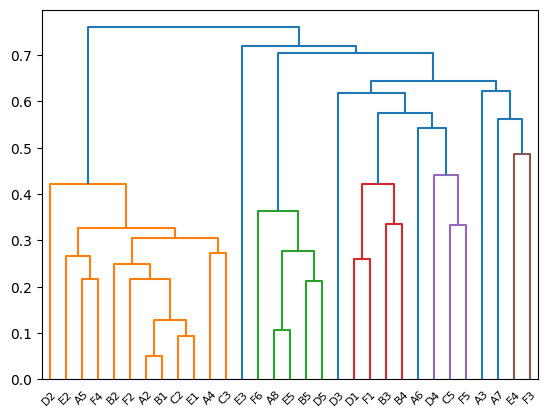

In [76]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram


from helpers.bert import bert_embedding

def plot_dendrogram(model, dictionary, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    def llf(id):
        if id < n_samples:
            return dictionary[id]["variation_index"]
        else:
            return '[%d %d %d]' % (linkage_matrix[id, 0], linkage_matrix[id, 1], linkage_matrix[id, 2])

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_label_func=llf, **kwargs)


def cluster_similar_steps(variations):
    """
    cluster similar steps together
    """

    linearized = [step for variation in variations for step in variation]
    print([step["variation_index"] for step in linearized])

    N = len(linearized)

    embeddings = bert_embedding([step["headline"] for step in linearized])

    # sim_matrix = np.zeros((N, N))
    # for i in range(N):
    #     for j in range(i+1, N):
    #         sim_matrix[i][j] = np.dot(embeddings[i], embeddings[j])
    #         sim_matrix[j][i] = sim_matrix[i][j]
    
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=0,
        linkage='average',
        metric='cosine'
    ).fit(embeddings)

    plot_dendrogram(clustering, linearized, truncate_mode='level', p=10)
    
    clusters = {}
    for i, cluster_id in enumerate(clustering.labels_):
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(linearized[i])
    return clusters

variations = []
task = ds["activity_info"][0]

print(task["task"])

for kk, vv in task["variations"].items():
    variations.append(vv)
result = cluster_similar_steps(variations)

for kk, vv in result.items():
    print("Cluster", kk)
    for step in vv:
        print(step["variation_index"], step["headline"])
    print()

## Check images

In [77]:
import cv2
import matplotlib.pyplot as plt

from helpers.clip import ClipModel

import json

def get_sentence_frame_paths(video):
    frames = []
    for sentence in video["sentences"]:
        length = len(sentence["frame_paths"])
        if length == 0:
            continue
        frames.append(sentence["frame_paths"][length//2])
    return frames

def get_all_frame_paths(video):
    return [frame["path"] for frame in video["frames"].values()]

def print_single_object(model, subgoal, key, obj):
    print(f"- {subgoal} - {key.capitalize()} = {obj['name']}")
    print(f"\t- {obj['description']}")
    print(f"\t- {obj['caption']}")
    img_path = obj["frame_paths"][0]
    if model:
        img_paths = model.find_similar_per_text([
            obj["caption"],
            obj["description"],
            "random object",
        ])
        img_path = img_paths[0]
    ### Print image
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print()
    print()

def print_all_objects(video, frame_paths):             
    keys = ['materials', 'tools', 'outcomes']
    print(f"# Video: {video['video_id']}")
    model = None
    if len(frame_paths) > 0:
        model = ClipModel(frame_paths)
    for summary in video['subgoal_summaries'].values():
        for key in summary:
            if key not in keys:
                continue
            for obj in summary[key]:
                print_single_object(model, summary['title'], key, obj)


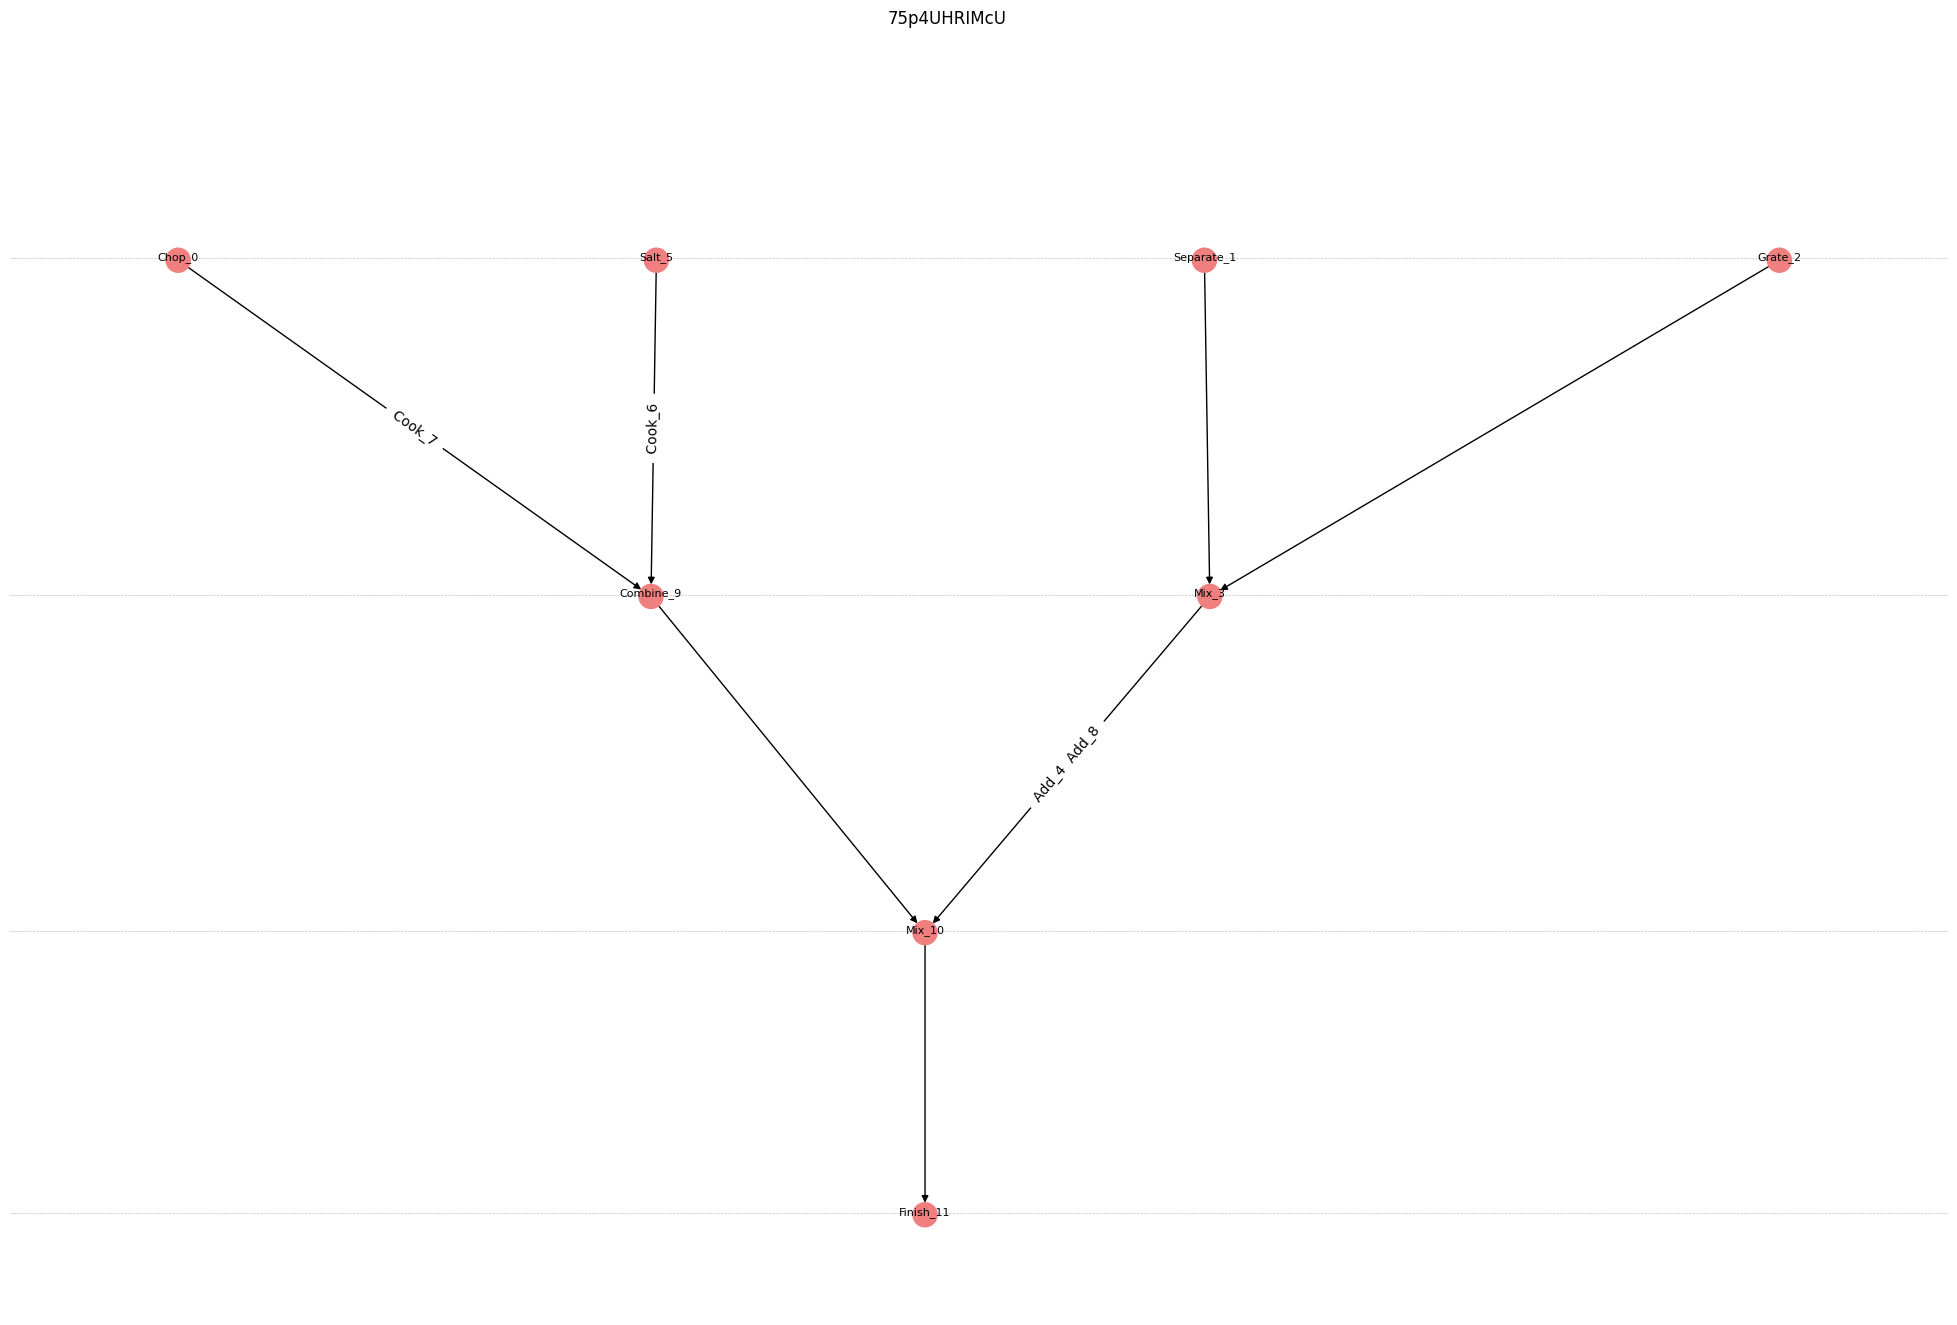

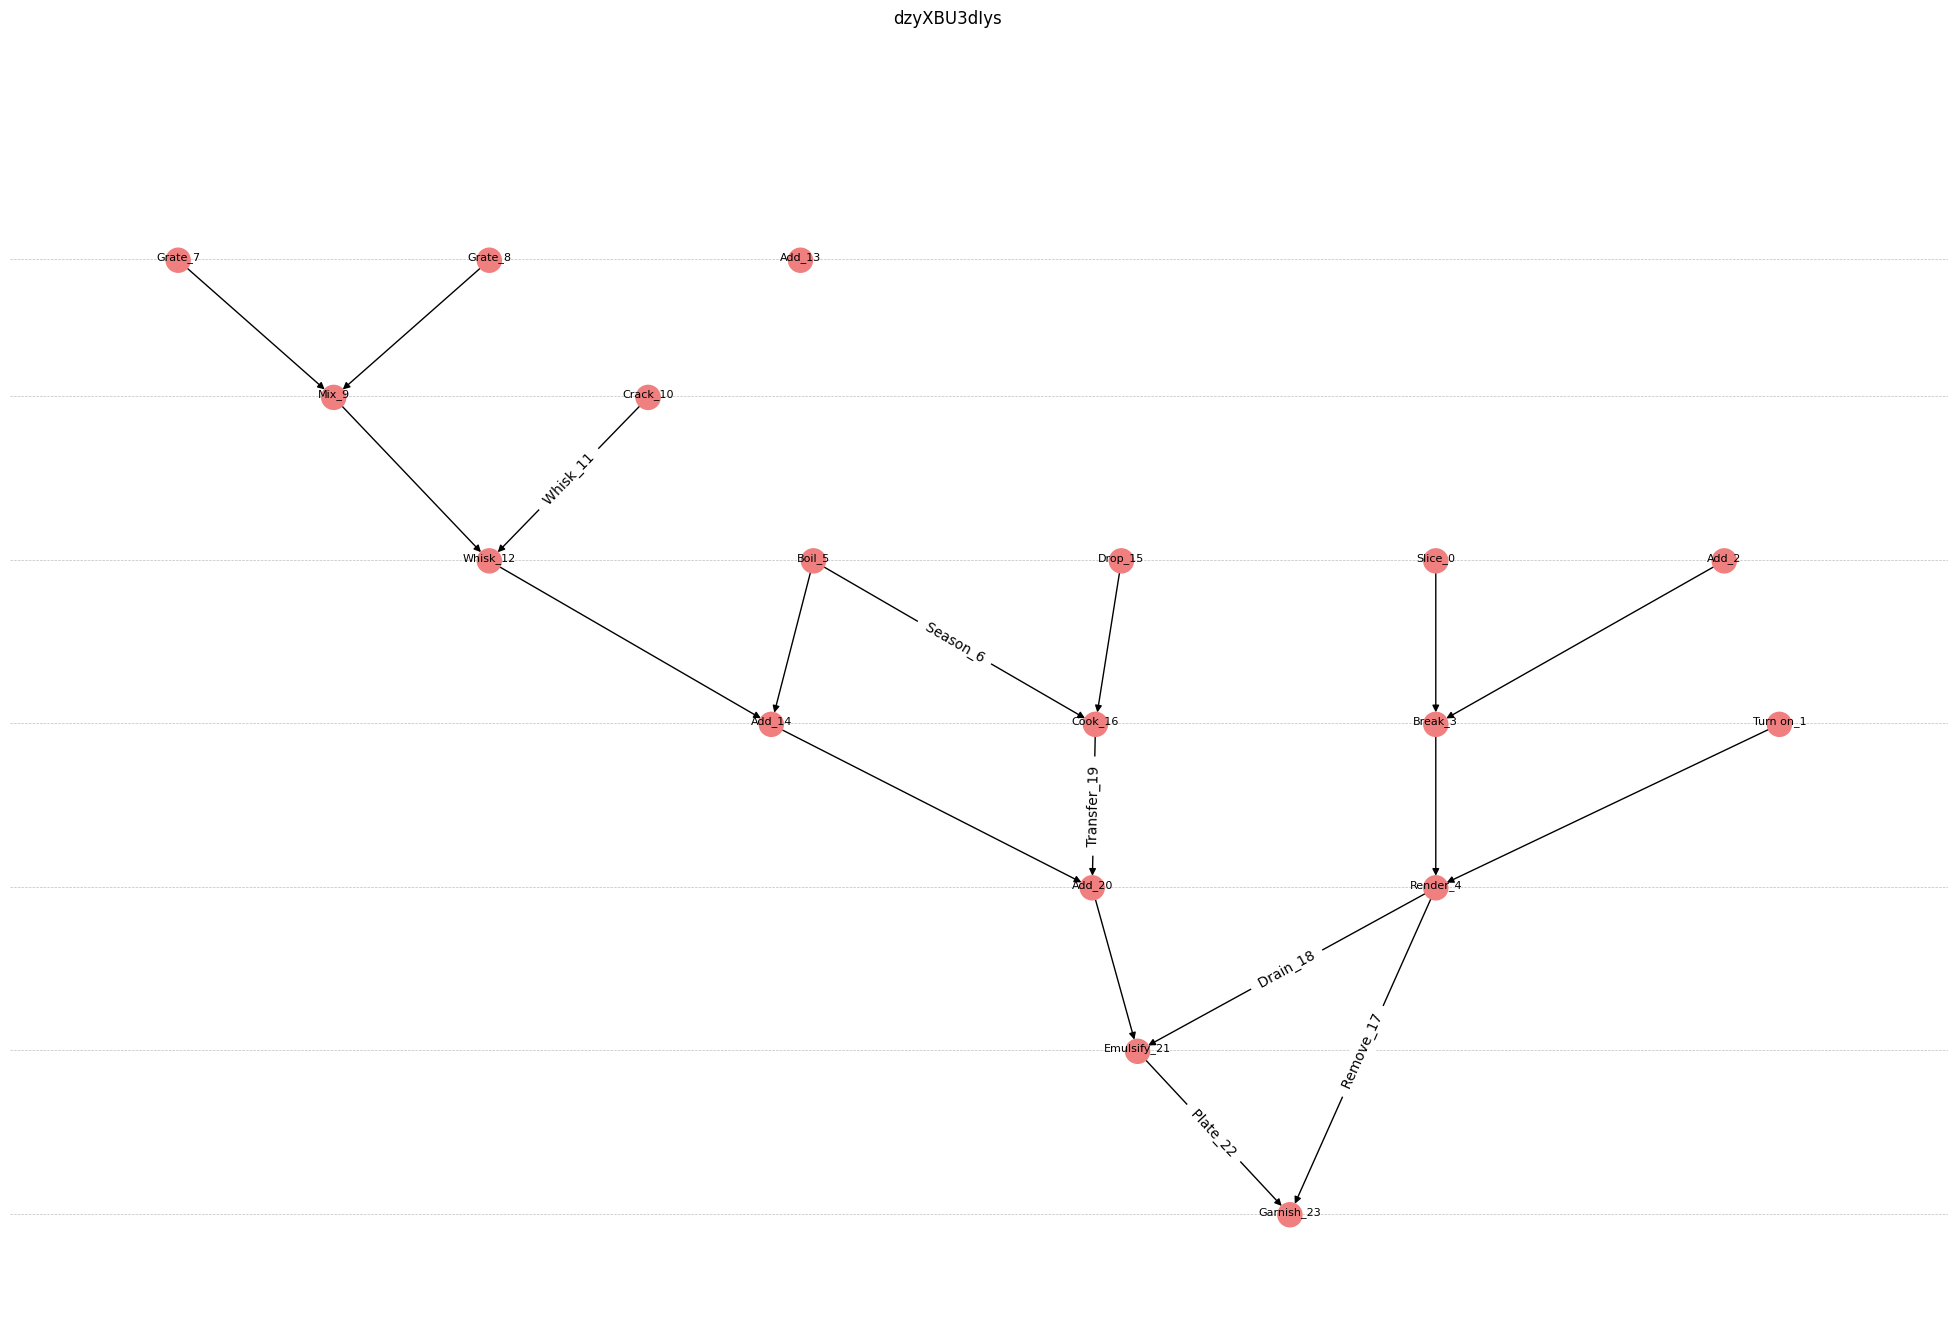

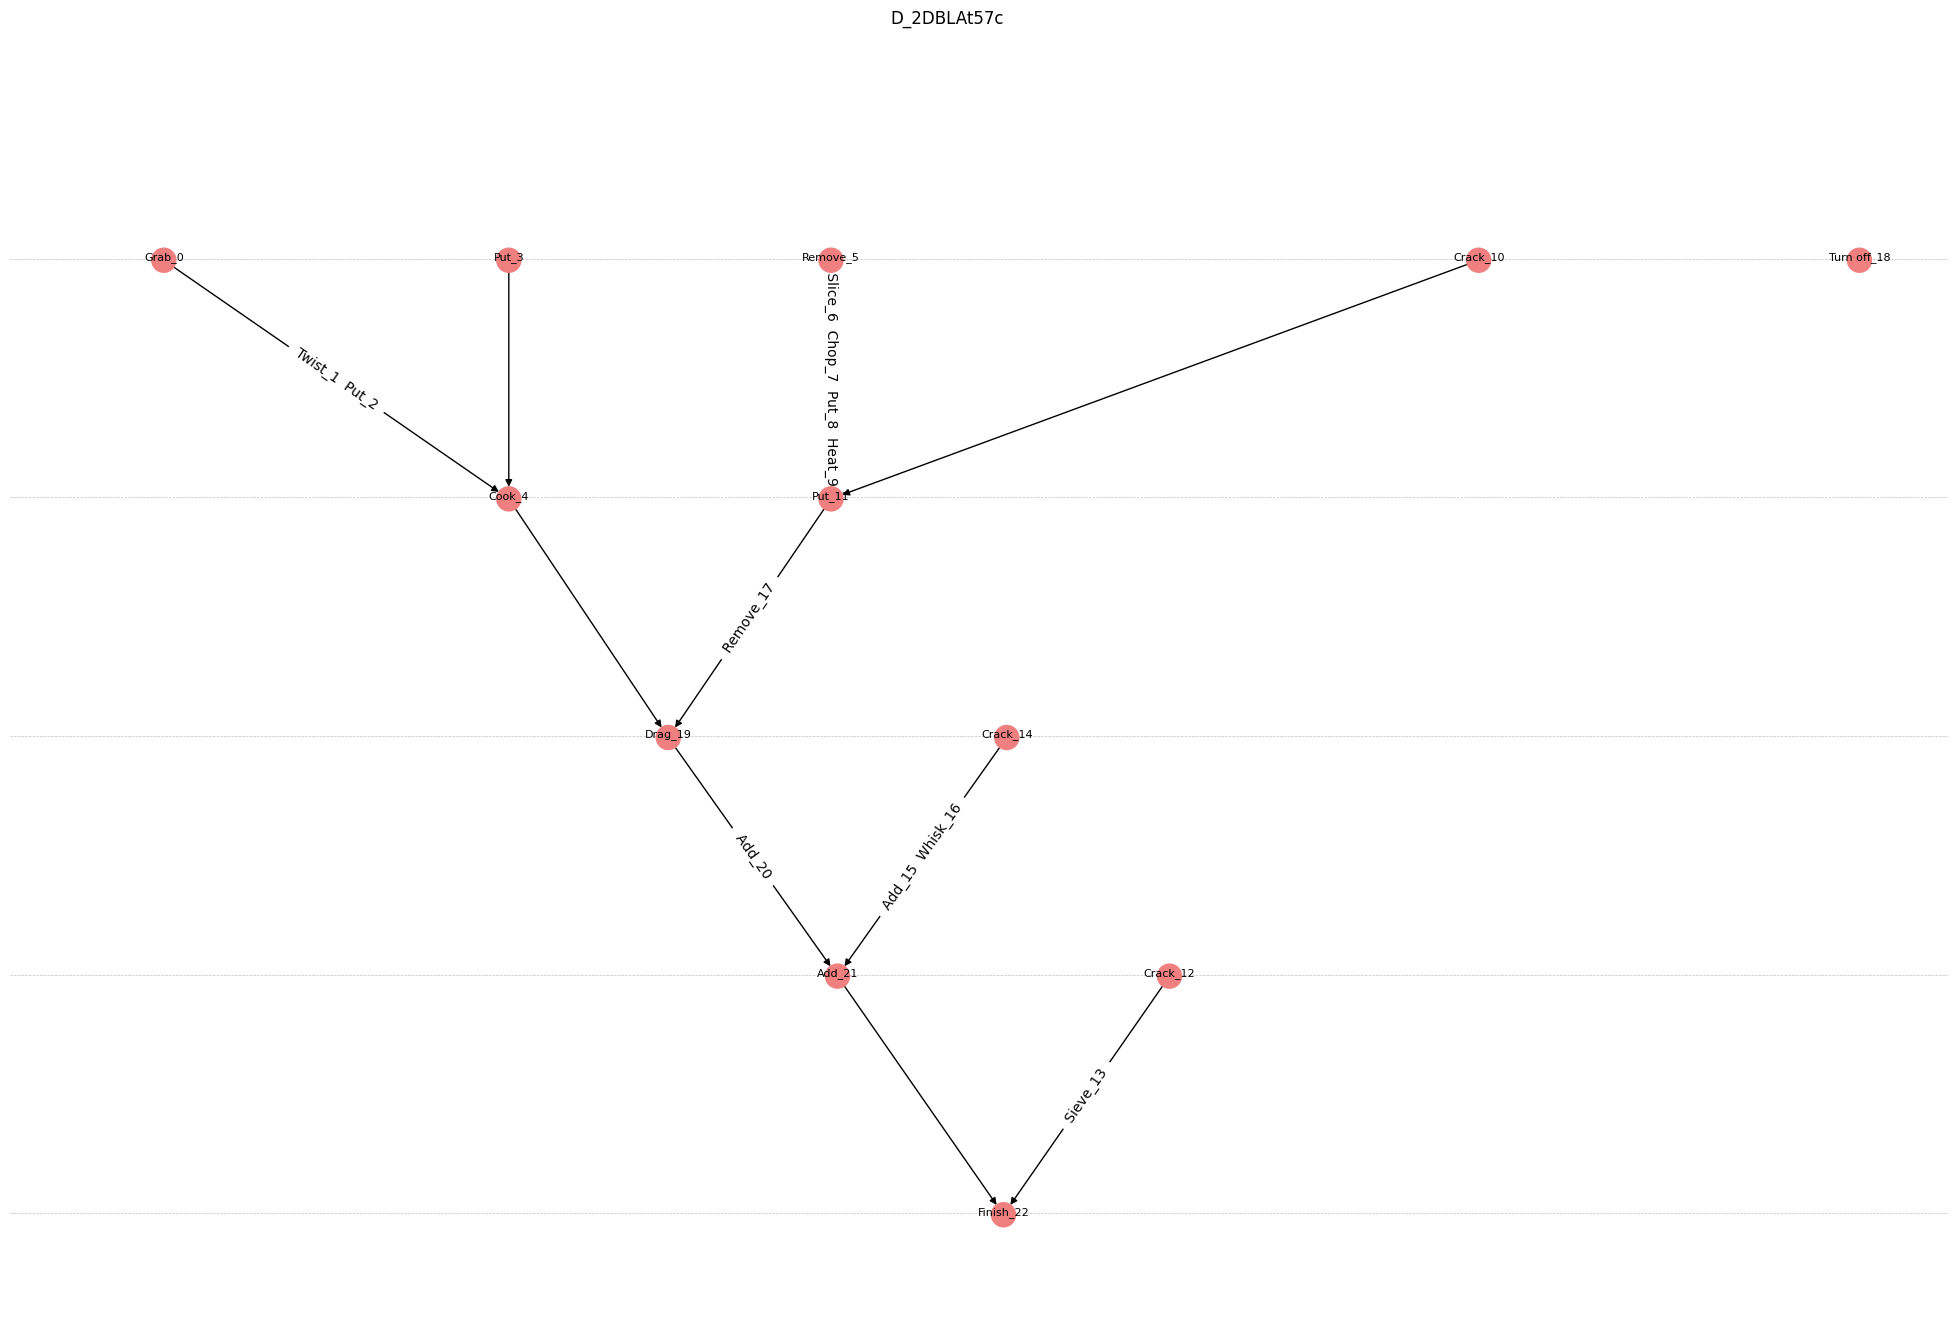

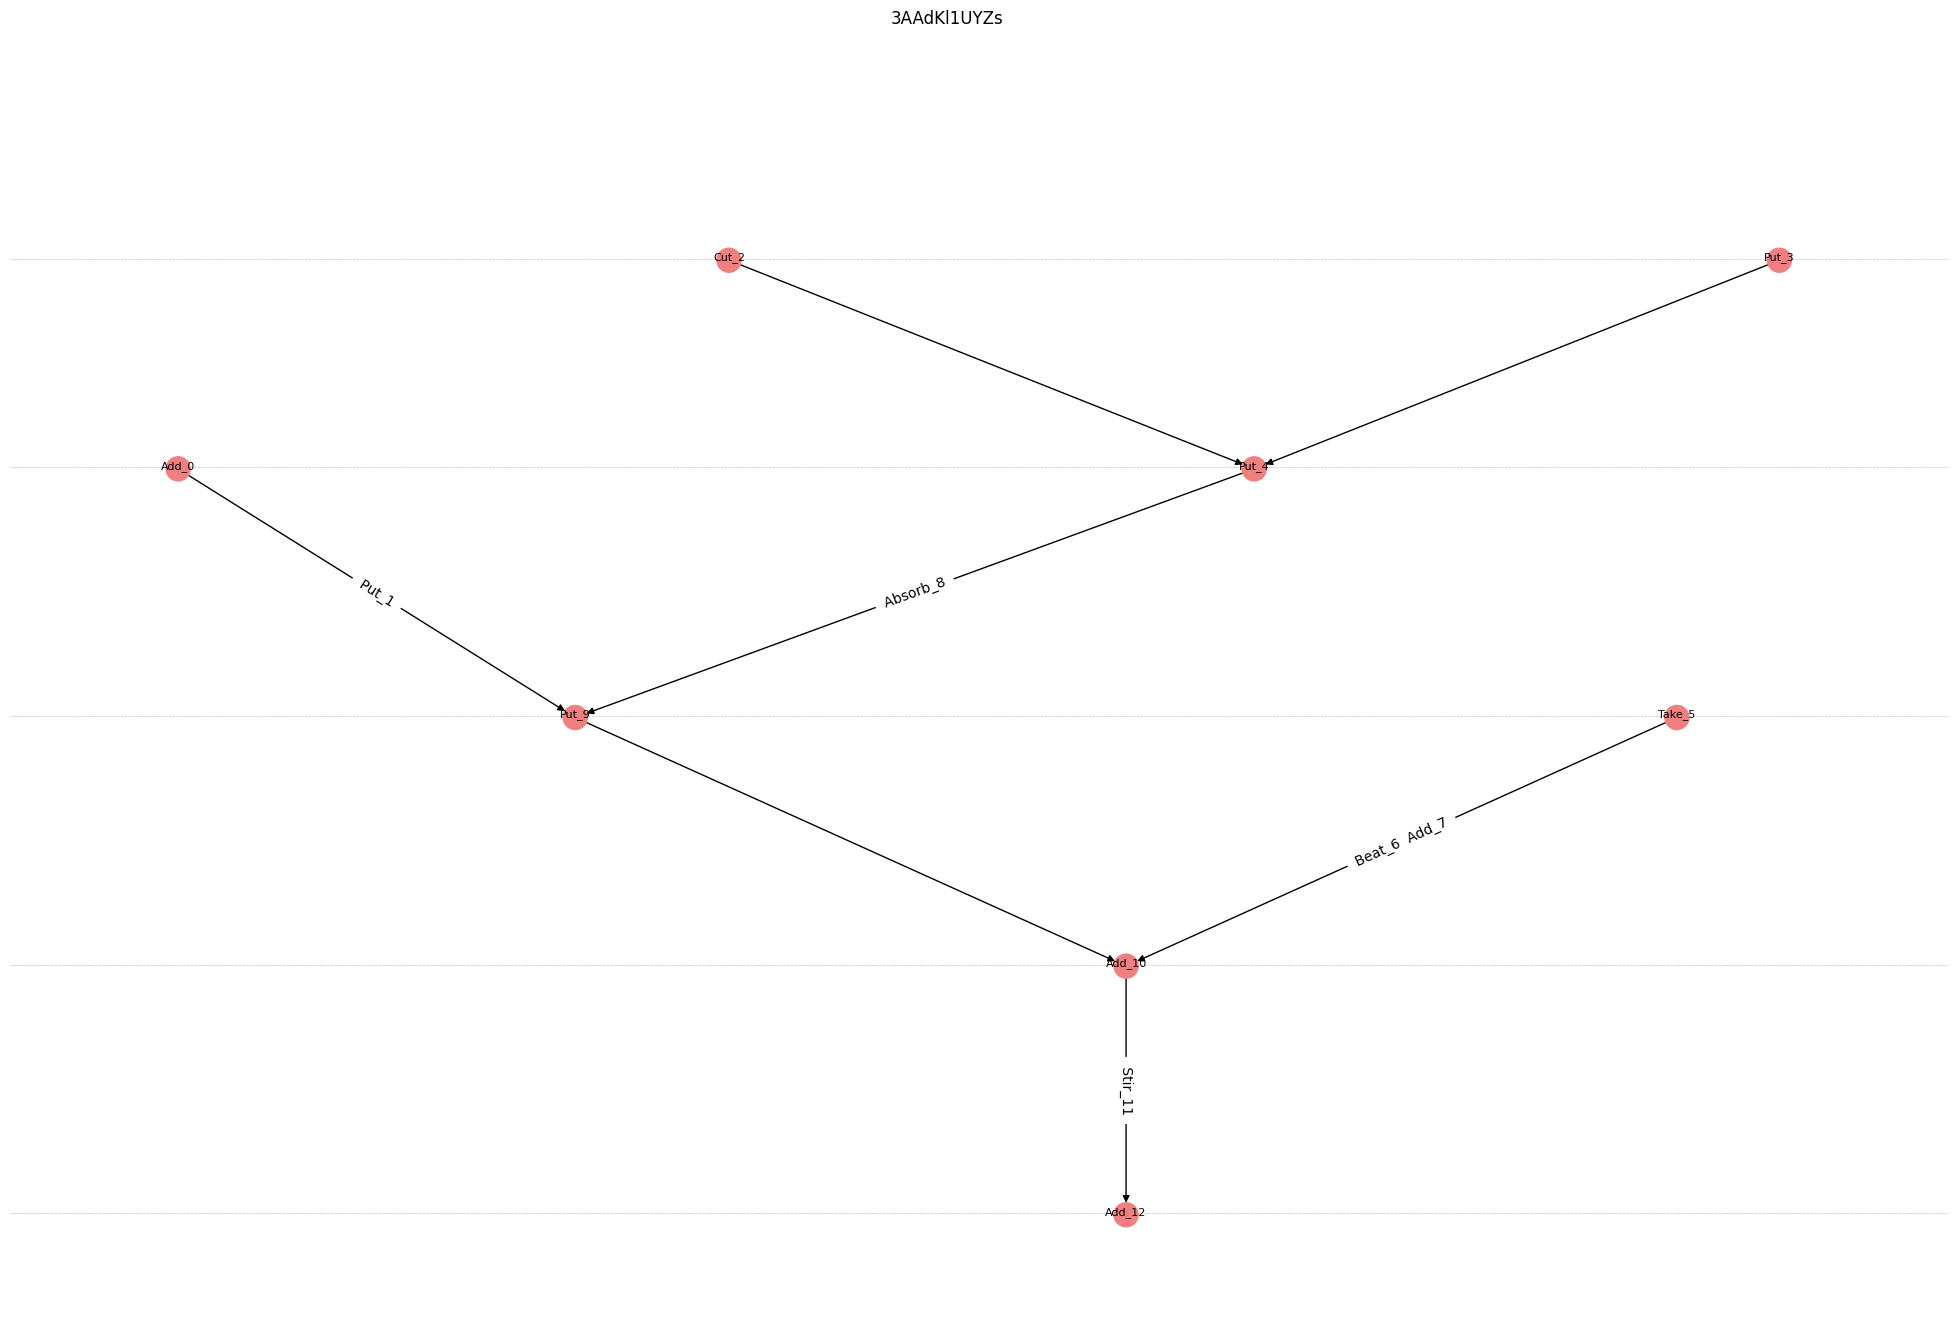

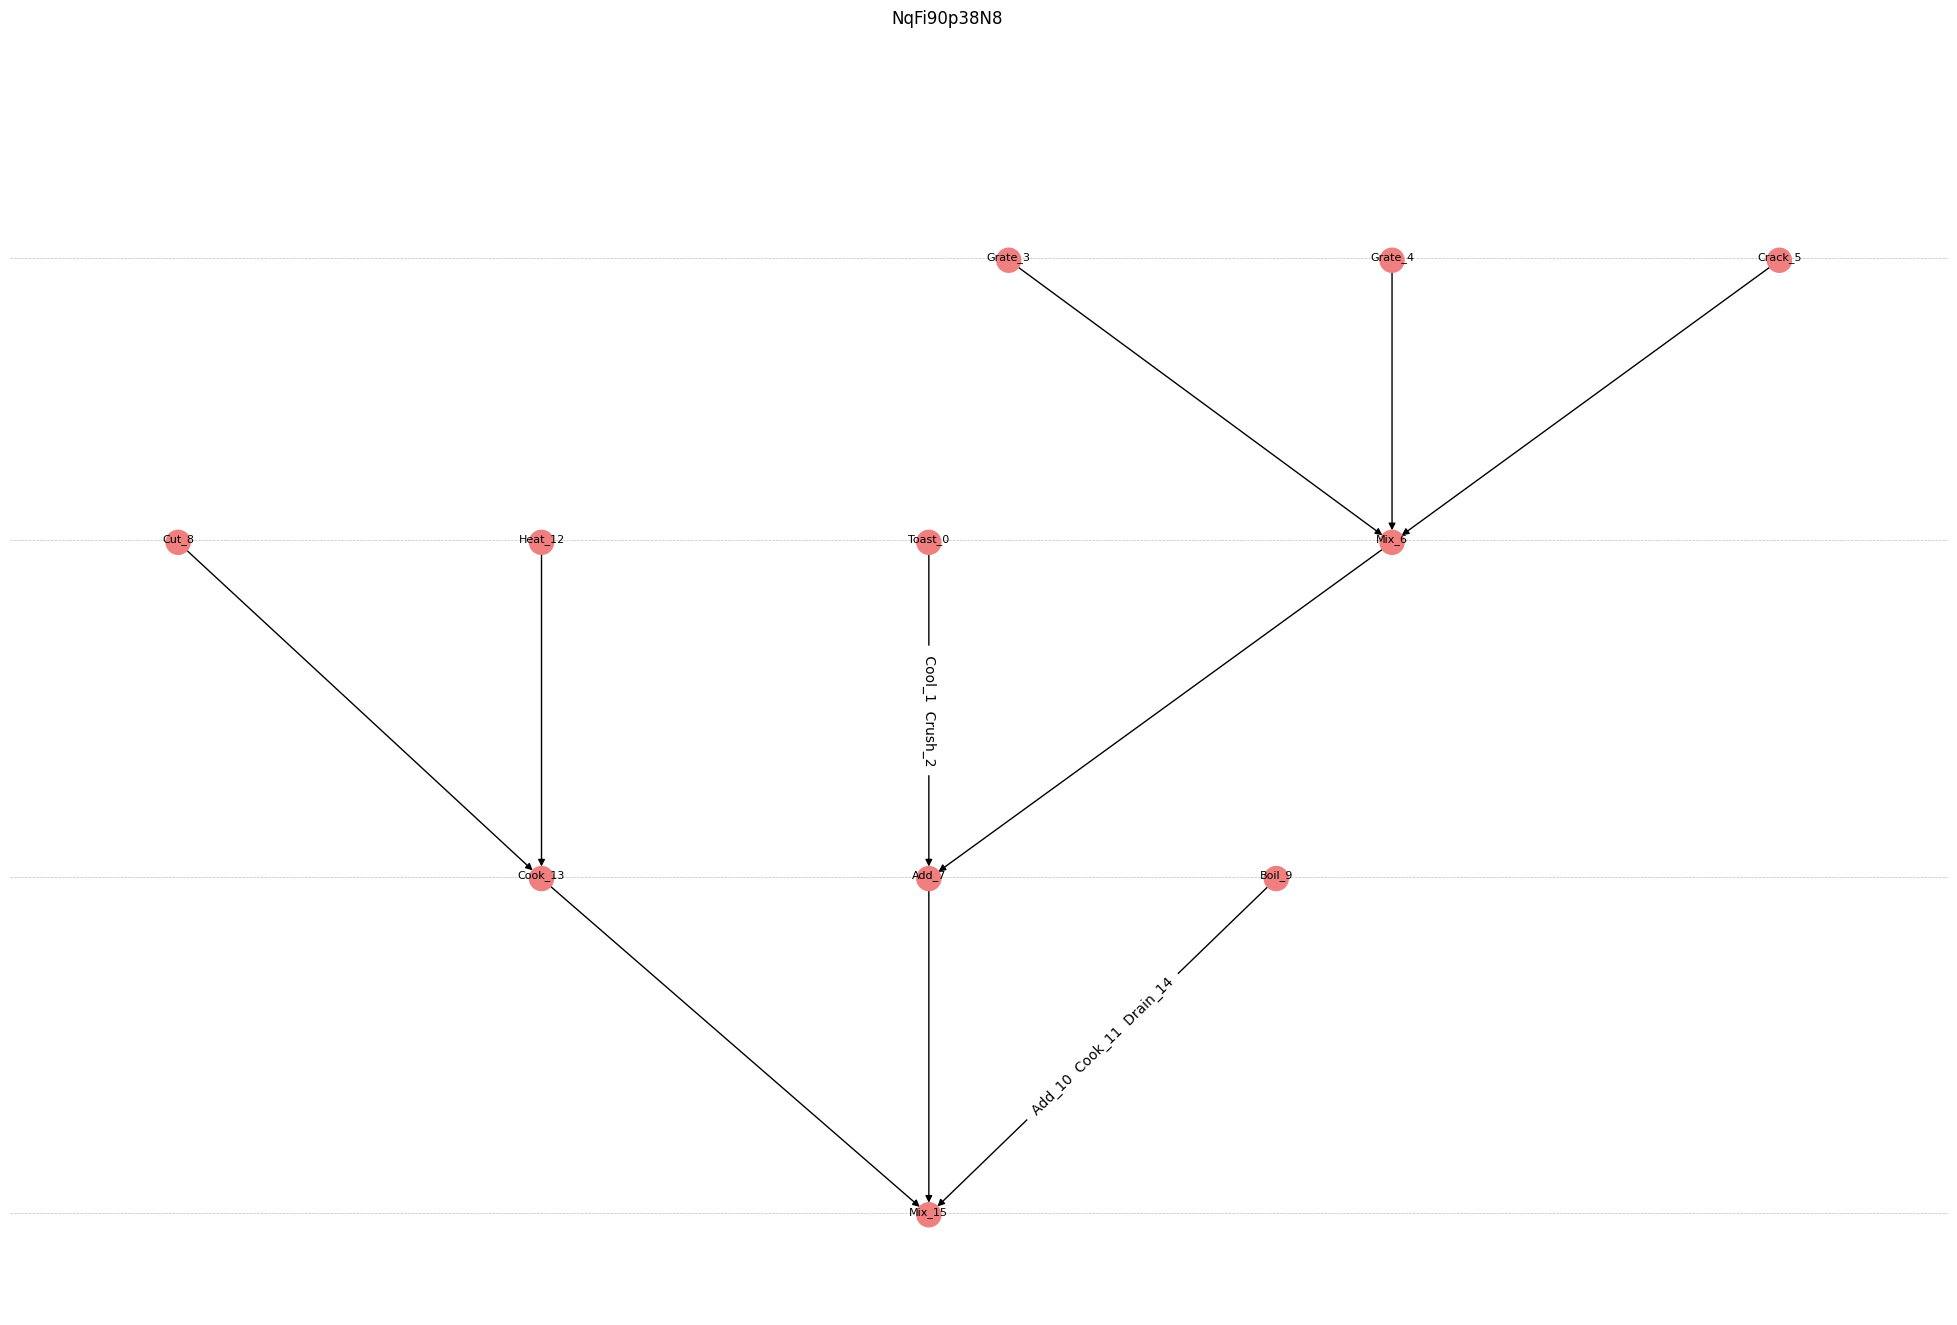

In [ ]:
from helpers.bert import clustering_custom

import networkx as nx

task_id = "carbonara"  # Replace with your actual task_id
video_file_path = f'static/results/{task_id}/video_data.json'
subgoal_file_path = f'static/results/{task_id}/subgoal_data.json'

with open(video_file_path, 'r') as file:
    video_data = json.load(file)

with open(subgoal_file_path, 'r') as file:
    subgoal_data = json.load(file)

def visualize_graph(G, ax):
    node_colors = {
        "material": "skyblue",
        "tool": "lightgreen",
        "action": "lightcoral",
        "outcome": "skyblue"
    }
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=TDshowboxes')
    nx.draw_networkx_nodes(G, pos, node_color=[node_colors[G.nodes[node]["type"]] for node in G.nodes], ax=ax)
    ### add edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
    nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes}, font_size=8, verticalalignment='baseline', ax=ax)
    ### add separating horizontal lines between generations and add labels

    unique_y = list(set([xy[1] for xy in pos.values()]))
    unique_y = sorted(unique_y)
    for i, y in enumerate(unique_y):
        ax.axhline(y=y + 0.5, color='gray', linestyle='--', linewidth=0.5, zorder=0, alpha=0.5)
    ax.set_axis_off()

def build_and_visualize_graph(steps, ax):
    """
    steps: list of dictionaries with keys "action", "materials", "tools", and "outcomes"
    """
    nodes = {}
    for i, step in enumerate(steps):
        action = step["action"] + "_" + str(i)
        materials = step["materials"]
        tools = step["tools"]
        outcomes = step["outcomes"]
        for material in materials:
            if material not in nodes:
                nodes[material] = {
                    "edges": [],
                    "type": "material",
                }
            nodes[material]["edges"].append(action)
        for tool in tools:
            if tool not in nodes:
                nodes[tool] = {
                    "edges": [],
                    "type": "tool",
                }
            nodes[tool]["edges"].append(action)
        if action not in nodes:
            nodes[action] = {
                "edges": [],
                "type": "action",
            }
        for outcome in outcomes:
            if outcome not in nodes:
                nodes[outcome] = {
                    "edges": [],
                    "type": "outcome",
                }
            nodes[action]["edges"].append(outcome)
    ### Visualize directed graph the graph should flow to the bottom
    G = nx.DiGraph()
    for node, data in nodes.items():
        G.add_node(node, name=node, type=data["type"])
        for edge in data["edges"]:
            G.add_edge(node, edge, label="")

    simplified_G = nx.DiGraph()
    ### leave only the nodes that have type "action" and preserve all the edges
    for node in G.nodes:
        if G.nodes[node]["type"] != "action":
            continue
        simplified_G.add_node(node, name=node, type=G.nodes[node]["type"])
    for edge in G.edges:
        x, y = edge
        if x not in simplified_G.nodes:
            continue
        if y in simplified_G.nodes:
            continue
        for other_edge in G.edges:
            xx, yy = other_edge
            if xx != y:
                continue
            if yy not in simplified_G.nodes:
                continue
            ### check if there is an edge from x to yy
            if (x, yy) in simplified_G.edges:
                continue
            simplified_G.add_edge(x, yy, label = "")
    G = simplified_G

    ### remove nodes that have 1 incoming and 1 outgoing edge
    while True:
        to_remove = []
        for node in G.nodes:
            if len(list(G.predecessors(node))) == 1 and len(list(G.successors(node))) == 1:
                to_remove.append(node)
        if len(to_remove) == 0:
            break
        
        for node in to_remove:
            ### connect the predecessors and successors
            pred = list(G.predecessors(node))[0]
            pred_edge_label = G[pred][node]["label"]
            succ = list(G.successors(node))[0]
            succ_edge_label = G[node][succ]["label"]
            new_label = pred_edge_label + " " + node + " " + succ_edge_label
            G.add_edge(pred, succ, label=new_label)
            G.remove_node(node)

    visualize_graph(G, ax)

def get_steps(all_steps, start, finish):
    filter_out = ["hands", "hand"]
    # filter_out = []
    def filter_list(arr):
        return [x for x in arr if x not in filter_out]

    actions_set = []
    steps = []
    for step in all_steps[start:finish]:
        materials = step["inputs"]
        # tools = step["tools"]
        outcomes = step["outcomes"]
        steps.append({
            "action": step["action"],
            "materials": filter_list(materials),
            "tools": [],
            "outcomes": filter_list(outcomes),
        })
        is_new_action = True
        for action in actions_set:
            if action == step["action"]:
                is_new_action = False
                break
        if is_new_action:
            actions_set.append(step["action"])
    return actions_set, steps


def cluster_outcomes(tagged_outcomes, threshold=0.8):
    outcomes = []
    for tagged_outcome in tagged_outcomes:
        outcomes.append(tagged_outcome["outcome"])
    labels = clustering_custom(outcomes, threshold)
    #### show clusters
    clusters = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(tagged_outcomes[i])
    return clusters

### cluster outcomes
# tagged_outcomes = []
# for video in video_data:
#     for step in video["steps"]:
#         for outcome in step["outcomes"]:
#             tagged_outcomes.append({
#                 "outcome": outcome,
#                 "tag": step["action"],
#                 "video": video["video_id"]
#             })

# clusters = cluster_outcomes(tagged_outcomes)
# clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)
# print(json.dumps(clusters, indent=4))

### show the trees
for video in video_data:

    ### print full tree
    fig, axs = plt.subplots(1, 1, figsize=(25, 15))
    actions_set, steps = get_steps(video["steps"], 0, len(video["steps"]))
    build_and_visualize_graph(steps, axs)
    actions_set, steps = get_steps(video["steps"], 0, len(video["steps"]))
    
    ### print subgoals
    # fig, axs = plt.subplots(1, len(video["subgoals"]), figsize=(5 * len(video["subgoals"]), 10))
    
    # for index, subgoal in enumerate(video["subgoals"]):
    #     actions_set, steps = get_steps(video["steps"], subgoal["start_index"], subgoal["finish_index"])
    #     build_and_visualize_graph(steps, axs[index])
    #     axs[index].set_title(subgoal["title"])

    #     # print(f"## Subgoal {index + 1}: {subgoal['title']}")
    #     # print(f"Description: {subgoal['description']}")
    #     # print(actions_set)
    fig.suptitle(f"{video['video_id']}")
    plt.show()
    print()

# info_per_subgoal = {}

# for video in video_data:
#     for subgoal in video["subgoals"]:
#         if subgoal["title"] not in info_per_subgoal:
#             info_per_subgoal[subgoal["title"]] = []
#         actions_set, steps = get_steps(video["steps"], subgoal["start_index"], subgoal["finish_index"])
#         info_per_subgoal[subgoal["title"]].append({
#             "video_id": video["video_id"],
#             "description": subgoal["description"],
#             "steps": steps,
#             "actions_set": actions_set,
#         })

In [28]:
materials_per_subgoal = {}
tools_per_subgoal = {}
steps_per_subgoal = {}
outcomes_per_subgoal = {}
for video in video_data:
    for id, summary in video['subgoal_summaries'].items():
        id = summary['title']
        materials = summary.get('materials', [])
        tools = summary.get('tools', [])
        steps = summary.get('steps', [])
        outcomes = summary.get('outcomes', [])
        if id not in materials_per_subgoal:
            materials_per_subgoal[id] = []
        if id not in tools_per_subgoal:
            tools_per_subgoal[id] = []
        if id not in steps_per_subgoal:
            steps_per_subgoal[id] = []
        if id not in outcomes_per_subgoal:
            outcomes_per_subgoal[id] = []
        for material in materials:
            materials_per_subgoal[id].append(video["video_id"] + "-" + material['name'])
        for tool in tools:
            tools_per_subgoal[id].append(video["video_id"] + "-" + tool['name'])
        for step in steps:
            steps_per_subgoal[id].append(step["description"])
        for outcome in outcomes:
            outcomes_per_subgoal[id].append(outcome["name"])

print(json.dumps(materials_per_subgoal, indent=4))

print(json.dumps(tools_per_subgoal, indent=4))

print(json.dumps(steps_per_subgoal, indent=4))

print(json.dumps(outcomes_per_subgoal, indent=4))

{}
{}
{}
{}


In [ ]:
keys = ['materials', 'tools', 'outcomes']
for video in video_data:
    print(f"# Video: {video['video_id']}")
    frame_paths = [frame["path"] for frame in video["frames"].values()]
    model = ClipModel(frame_paths)
    for subgoal, summary in video['subgoal_summaries'].items():
        for key in summary:
            if key not in keys:
                continue
            for obj in summary[key]:
                print(f"- {subgoal} - {key.capitalize()} - {obj['name']}")
                print(f"\t- {obj['description']}")
                print(f"\t- {obj['caption']}")
                # img_path = obj["frame_paths"][0]
                
                img_paths = model.find_similar_per_text([
                    obj['description'],
                    obj['caption'],
                    "random object",
                ])
                img_path = img_paths[0]
                ### Print image
                print(img_path)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                print()
                print()

## SIMILARITY

In [ ]:
for video in video_data:
    print("##", video['video_id'])
    cur_steps = [*video['steps']]
    cur_subgoals = [*video['subgoals']]

    cur_subgoals = sorted(cur_subgoals, key=lambda x: x['start'])
    print("### Subgoals:")
    for subgoal in cur_subgoals:
        print("`", subgoal["title"], "`", end=" --> ")
    print()
    for step in cur_steps:
        print('-', step)
        # for subgoal in cur_subgoals:
        #     if step in subgoal['original_steps']:
        #         print('  -', subgoal['title'])
        print()

## 75p4UHRIMcU
### Subgoals:
`  ` --> ` Prepare Ingredients ` --> ` Prepare Egg Mixture ` --> ` Cook Pasta ` --> ` Cook Bacon ` --> ` Mix Egg and Cheese ` --> ` Combine Pasta and Bacon ` --> ` Cook Pasta ` --> ` Create Sauce ` --> ` Finish and Serve ` --> 
- Chop bacon into small pieces.

- Cook the bacon in a pan until crispy, then turn off the heat and let it cool slightly.

- Separate egg yolks from egg whites and place the yolks in a bowl.

- Grate pecorino romano cheese and add it to the egg yolks.

- Add freshly ground black pepper to the egg yolk and cheese mixture and mix well.

- Boil water in a pot, add salt, and cook spaghetti until al dente.

- Reserve some pasta water before draining the spaghetti.

- Add a small amount of pasta water to the egg yolk and cheese mixture to help melt the cheese.

- Transfer the cooked spaghetti directly from the pot to the pan with bacon.

- Mix the spaghetti with the bacon and then add the egg yolk mixture, stirring quickly to coat the past

/home/bekzat/.conda/envs/starlab-video-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


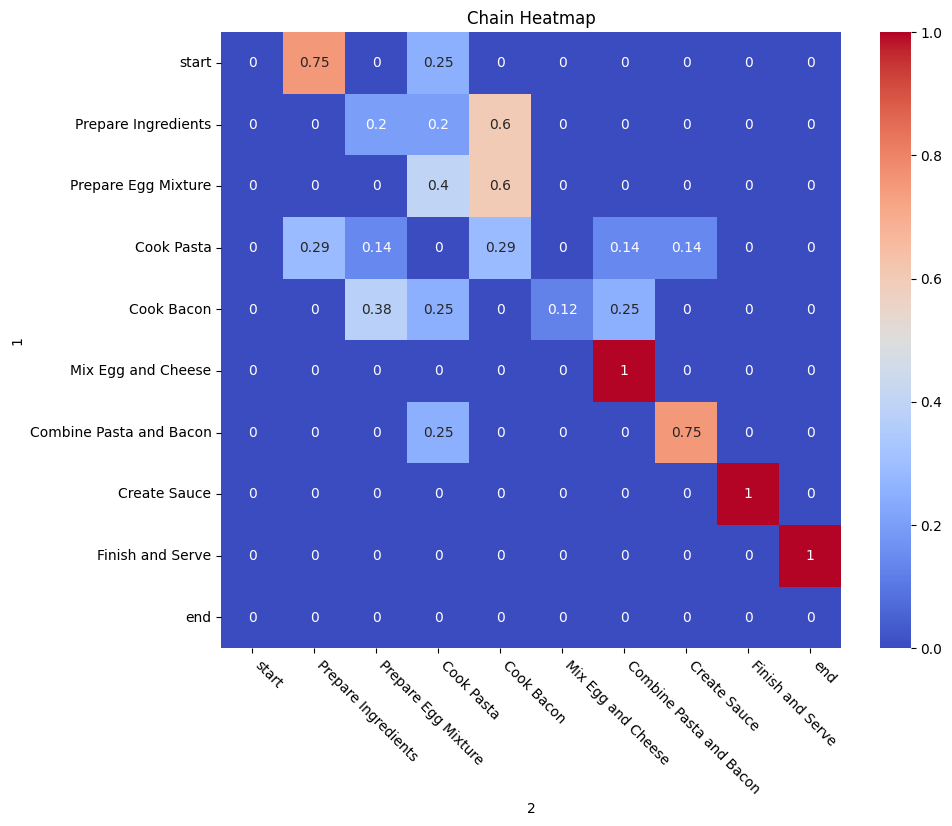

In [ ]:
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

def draw_similarity_heatmap(steps_0, steps_1):
    # Load pre-trained model
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    # Compute embeddings
    embeddings_video_0 = model.encode(steps_0, convert_to_tensor=True).cpu()
    embeddings_video_1 = model.encode(steps_1, convert_to_tensor=True).cpu()

    # Compute cosine similarity matrix
    cosine_sim_matrix = util.pytorch_cos_sim(embeddings_video_0, embeddings_video_1).numpy()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_sim_matrix, annot=True, xticklabels=steps_1, yticklabels=steps_0, cmap='coolwarm')
    # Tilt x-axis labels
    plt.xticks(rotation=-45, ha='left')

    plt.xlabel('Steps Video 1')
    plt.ylabel('Steps Video 0')
    plt.title('Semantic Similarity Heatmap')
    plt.show()

def draw_chain_heatmap(step_sets):
    chain_count = {}
    nexts_count = {}
    for steps in step_sets:
        prev = 'start'
        for step in [*steps, 'end']:
            if prev not in chain_count:
                chain_count[prev] = {}
            if step not in chain_count[prev]:
                chain_count[prev][step] = 0
            chain_count[prev][step] += 1

            if prev not in nexts_count:
                nexts_count[prev] = 0
            nexts_count[prev] += 1
            prev = step
    
    keys = [*chain_count.keys(), 'end']

    chain_matrix = np.zeros((len(keys), len(keys)))
    for i, key in enumerate(keys):
        for j, key2 in enumerate(keys):
            if key in chain_count and key2 in chain_count[key]:
                chain_matrix[i, j] = chain_count[key][key2] / nexts_count[key]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(chain_matrix, annot=True, xticklabels=keys, yticklabels=keys, cmap='coolwarm')
    # Tilt x-axis labels
    plt.xticks(rotation=-45, ha='left')

    plt.xlabel('2')
    plt.ylabel('1')
    plt.title('Chain Heatmap')
    

combines = {
    # 'Prepare Meat': 'Prepare and Cook Meat',
    # 'Cook Meat': 'Prepare and Cook Meat',
    # 'Mix Egg and Cheese': 'Combine Ingredients',
    # 'Combine Pasta and Meat': 'Combine Ingredients',
    # 'Add Egg Mixture': 'Combine Ingredients',
}

step_sets = []
for video in video_data:
    cur_subgoals = [*video['subgoals']]
    cur_subgoals = sorted(cur_subgoals, key=lambda x: x['start'])
    steps = []
    for subgoal in cur_subgoals:
        if subgoal["title"] != '':
            if subgoal["title"] in combines:
                steps.append(combines[subgoal["title"]])
            else:
                steps.append(subgoal["title"])
    combined_steps = []
    for step in steps:
        if len(combined_steps) > 0 and combined_steps[-1] == step:
            continue
        combined_steps.append(step)
    step_sets.append(combined_steps)

draw_chain_heatmap(step_sets)


In [ ]:
import json
alignment_file_path = f'static/results/{task_id}/alignment_sets.json'

with open(alignment_file_path, 'r') as file:
    alignment_data = json.load(file)

In [111]:
pair_comparisons = {}
for approach, alignment_sets in alignment_data.items():
    for alignment_set in alignment_sets:
        video_id = alignment_set['video_id']
        alignments = alignment_set['alignments']
        for alignment in alignments:
            other_video_id = alignment['other_video_id']
            key = video_id + '-' + other_video_id
            if approach.endswith('baseline_1'):
                key = other_video_id + '-' + video_id
            if key not in pair_comparisons:
                pair_comparisons[key] = {}
            if approach not in pair_comparisons[key]:
                pair_comparisons[key][approach] = []
            pair_comparisons[key][approach].append(alignment)

video_id_to_index = {}
for pair, comparisons in pair_comparisons.items():
    video_0, video_1 = pair.split('-')
    if video_0 not in video_id_to_index:
        video_id_to_index[video_0] = len(video_id_to_index)
    if video_1 not in video_id_to_index:
        video_id_to_index[video_1] = len(video_id_to_index)
        

75p4UHRIMcU
24
0 Total - 5
Alternative - 5 Additional - 0
Subgoals - {'Prepare Ingredients'}
Aspects - {'materials', 'explanations'}
Video IDs - {'dzyXBU3dIys', '3AAdKl1UYZs', 'D_2DBLAt57c'}
Descriptions:
 Uses bacon instead of guanciale, which is traditional for carbonara.	
Bacon is used instead of guanciale.	
Bacon is used instead of guanciale, which is traditional for carbonara.	
Bacon is used instead of guanciale, which is traditional for carbonara.	
Bacon is used instead of guanciale, which is traditional for carbonara.


1 Total - 6
Alternative - 6 Additional - 0
Subgoals - {'Create Sauce', 'Prepare Ingredients', 'Prepare Egg Mixture'}
Aspects - {'materials', 'instructions'}
Video IDs - {'dzyXBU3dIys', '3AAdKl1UYZs', 'D_2DBLAt57c'}
Descriptions:
 Uses only egg yolks instead of a mix of whole eggs and yolks.	
Mentions using egg yolks and whole eggs without specifying the number.	
The sauce uses only egg yolks instead of whole eggs.	
Separate egg yolks from the whites.	
The tutoria

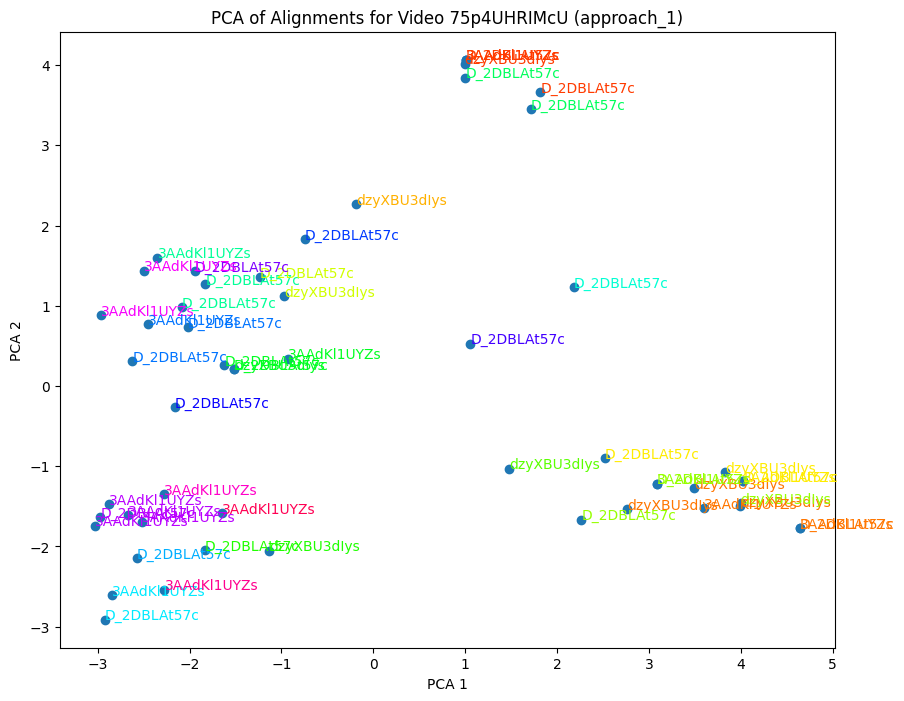

None


In [133]:
import json

from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

def combine_embed_plot_alignments(video_id, approach):
    # Collect all alignments for the given video_id
    alignments = []
    for pair, comparisons in pair_comparisons.items():
        video_0, video_1 = pair.split('-')
        if video_0 != video_id:
            continue
        for a, alignment_list in comparisons.items():
            if a != approach:
                continue 
            for alignment in alignment_list:
                alignments.append({
                    'text': alignment['alignment_description'],
                    'subgoal': alignment['subgoal_title'],
                    'relation': alignment['relation'],
                    'aspect': alignment['aspect'],
                    'video_id': video_1,
                })
    
    # Load pre-trained model
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    
    # Compute embeddings
    embeddings = model.encode([a['text'] for a in alignments], convert_to_tensor=True).cpu().numpy()

    similarity_matrix = util.pytorch_cos_sim(embeddings, embeddings).numpy()
    ### color alignments that have similarity > THRESHOLD into the same color
    THRESHOLD = 0.8
    
    colors = [0 for i in range(len(alignments))]
    n_colors = 0
    for i in range(len(alignments)):
        if colors[i] == 0:
            n_colors += 1
            colors[i] = n_colors
        for j in range(i+1, len(alignments)):
            if similarity_matrix[i, j] > THRESHOLD:
                colors[j] = colors[i]
    same_color = {}
    for i, a in enumerate(alignments):
        a['color'] = colors[i] - 1
        if a['color'] not in same_color:
            same_color[a['color']] = []
        same_color[a['color']].append(a)
    palette = sns.color_palette("hsv", n_colors)
    print(n_colors)
    for color, color_alignments in same_color.items():
        n_alternative = len([a for a in color_alignments if a['relation'] == 'alternative'])
        n_additional = len([a for a in color_alignments if a['relation'] == 'additional'])
        subgoals = set([a['subgoal'] for a in color_alignments])
        aspects = set([a['aspect'] for a in color_alignments])
        video_ids = set([a['video_id'] for a in color_alignments])
        print(color, "Total -", len(color_alignments),)
        print("Alternative -", n_alternative, "Additional -", n_additional)
        print("Subgoals -", subgoals)
        print("Aspects -", aspects)
        print("Video IDs -", video_ids)
        print("Descriptions:\n", "\t\n".join([a['text'] for a in color_alignments]))
        print()
        print()
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    # Plot PCA result
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    for i, a in enumerate(alignments):
        color = palette[a['color']]
        # label = f"{a['subgoal']} ({a['relation']}-{a['aspect']})"
        label = f"{a['video_id']}"
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), color=color)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title(f'PCA of Alignments for Video {video_id} ({approach})')
    plt.show()

# Example usage
video_id = [*video_id_to_index.keys()][0]
print(video_id)
pca_result = combine_embed_plot_alignments(video_id, 'approach_1')
print(pca_result)

# INPUT/METHOD/OUTPUT distance calculation

In [105]:
def get_distances(aspect_groups):
    distance_matrix_per_subgoal_aspect = {}

    approach = 'approach_1'
    N = len(video_id_to_index)

    for pair, comparisons in pair_comparisons.items():
        video_0, video_1 = pair.split('-')
        index_0 = video_id_to_index[video_0]
        index_1 = video_id_to_index[video_1]

        for alignment in comparisons[approach]:
            subgoal = alignment['subgoal_title']
            aspect = alignment['aspect']
            relation = alignment['relation']
            if subgoal not in distance_matrix_per_subgoal_aspect:
                distance_matrix_per_subgoal_aspect[subgoal] = {}
            if aspect not in distance_matrix_per_subgoal_aspect[subgoal]:
                distance_matrix_per_subgoal_aspect[subgoal][aspect] = np.zeros((N, N))
            if relation == 'alternative':
                distance_matrix_per_subgoal_aspect[subgoal][aspect][index_0, index_1] += (alignment['importance'] - 1) / 4
                # distance_matrix_per_subgoal_aspect[subgoal][aspect][index_0, index_1] += 1

    def aggregate_distance_matrix(matrices, keys):
        result = np.zeros((N, N))
        found = False
        for key, matrix in matrices.items():
            if matrix is None:
                continue
            if key in keys:
                result += matrix
                found = True
        if not found:
            return None
        result /= len(keys)
        return result

    distance_matrix_per_subgoal = {}
    for subgoal, distance_matrix_per_aspect in distance_matrix_per_subgoal_aspect.items():
        result = np.zeros((N, N))
        for aspect_group in aspect_groups:
            cur_matrix = aggregate_distance_matrix(distance_matrix_per_aspect, aspect_group)
            if cur_matrix is None:
                continue
            result += cur_matrix
        distance_matrix_per_subgoal[subgoal] = result / len(aspect_groups)
        ## Normalize
        max_value = np.max(distance_matrix_per_subgoal[subgoal])
        if max_value > 0:
            distance_matrix_per_subgoal[subgoal] = distance_matrix_per_subgoal[subgoal] / max_value

    all_subgoals = [*distance_matrix_per_subgoal.keys()]
    distance_marix = aggregate_distance_matrix(distance_matrix_per_subgoal, all_subgoals)

    distance_matrices = {
        'video-level': distance_marix,
    }

    ## draw distance heatmap for each subgoal
    for subgoal, matrix in distance_matrix_per_subgoal.items():
        distance_matrices[subgoal] = matrix
    
    return distance_matrices

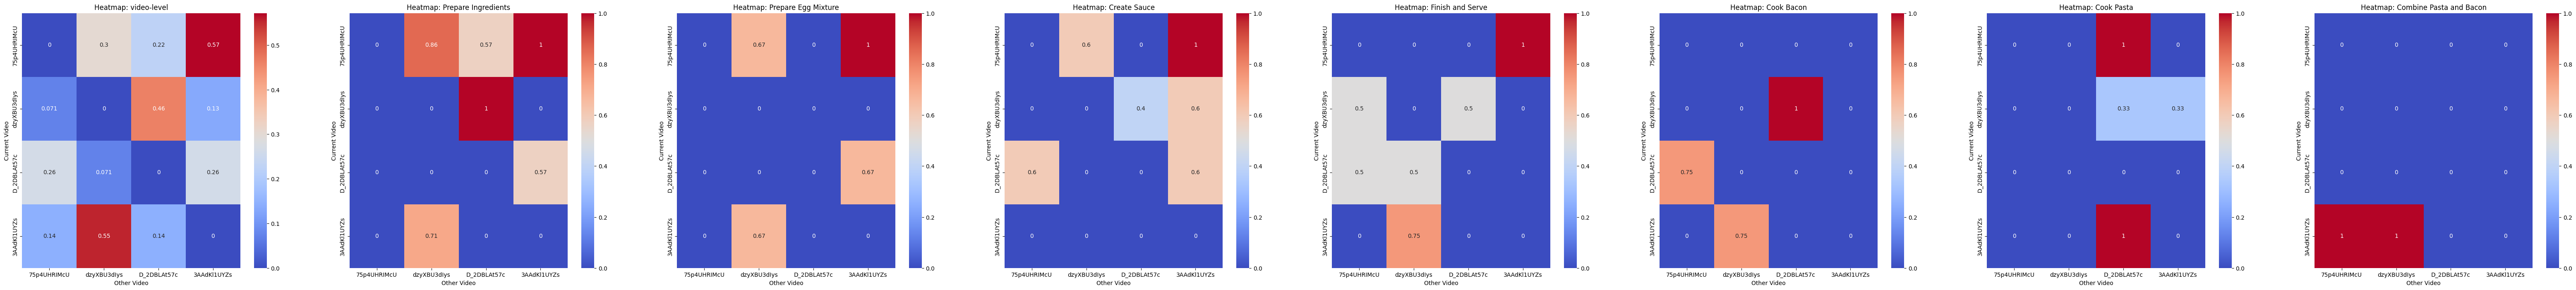

In [110]:
import math

def draw_heatmaps_of_matrices(distance_matrices, labels):
    ## draw multiple distance matrices in one figure make sure to square out the figure as much as possible
    fig, axs = plt.subplots(1, len(distance_matrices), figsize=(10 * len(distance_matrices), 8))

    for idx, (title, matrix) in enumerate(distance_matrices.items()):
        cur_ax = axs[idx]
        sns.heatmap(
            matrix,
            annot=True,
            ax=cur_ax,
            cmap='coolwarm',
            xticklabels=labels,
            yticklabels=labels,
            cbar=True,
        )
        cur_ax.set_title("Heatmap: " + title)
        cur_ax.set_xlabel('Other Video')
        cur_ax.set_ylabel('Current Video')
    plt.show()

groups = {
    'input': [
        ['materials'],
        # ['instructions', 'tools'], ### skip 'warnings', 'explanations', 'tips'
        # ['outcomes']
    ],
    'method': [
        # ['materials'],
        ['instructions', 'tools'], ### skip 'warnings', 'explanations', 'tips'
        # ['outcomes']
    ],
    'output': [
        # ['materials'],
        # ['instructions', 'tools'], ### skip 'warnings', 'explanations', 'tips'
        ['outcomes']
    ],
    "overall": [
        ['materials'],
        ['instructions', 'tools'], ### skip 'warnings', 'explanations', 'tips'
        ['outcomes']
    ],
}

distances_per_group = {}

for group in groups:
    distances_per_group[group] = get_distances(groups[group])

draw_heatmaps_of_matrices(distances_per_group['input'], [*video_id_to_index.keys()])

0.06304669061502151
0.026569586167800443
0.0036848072562358286
0.07995451162787856


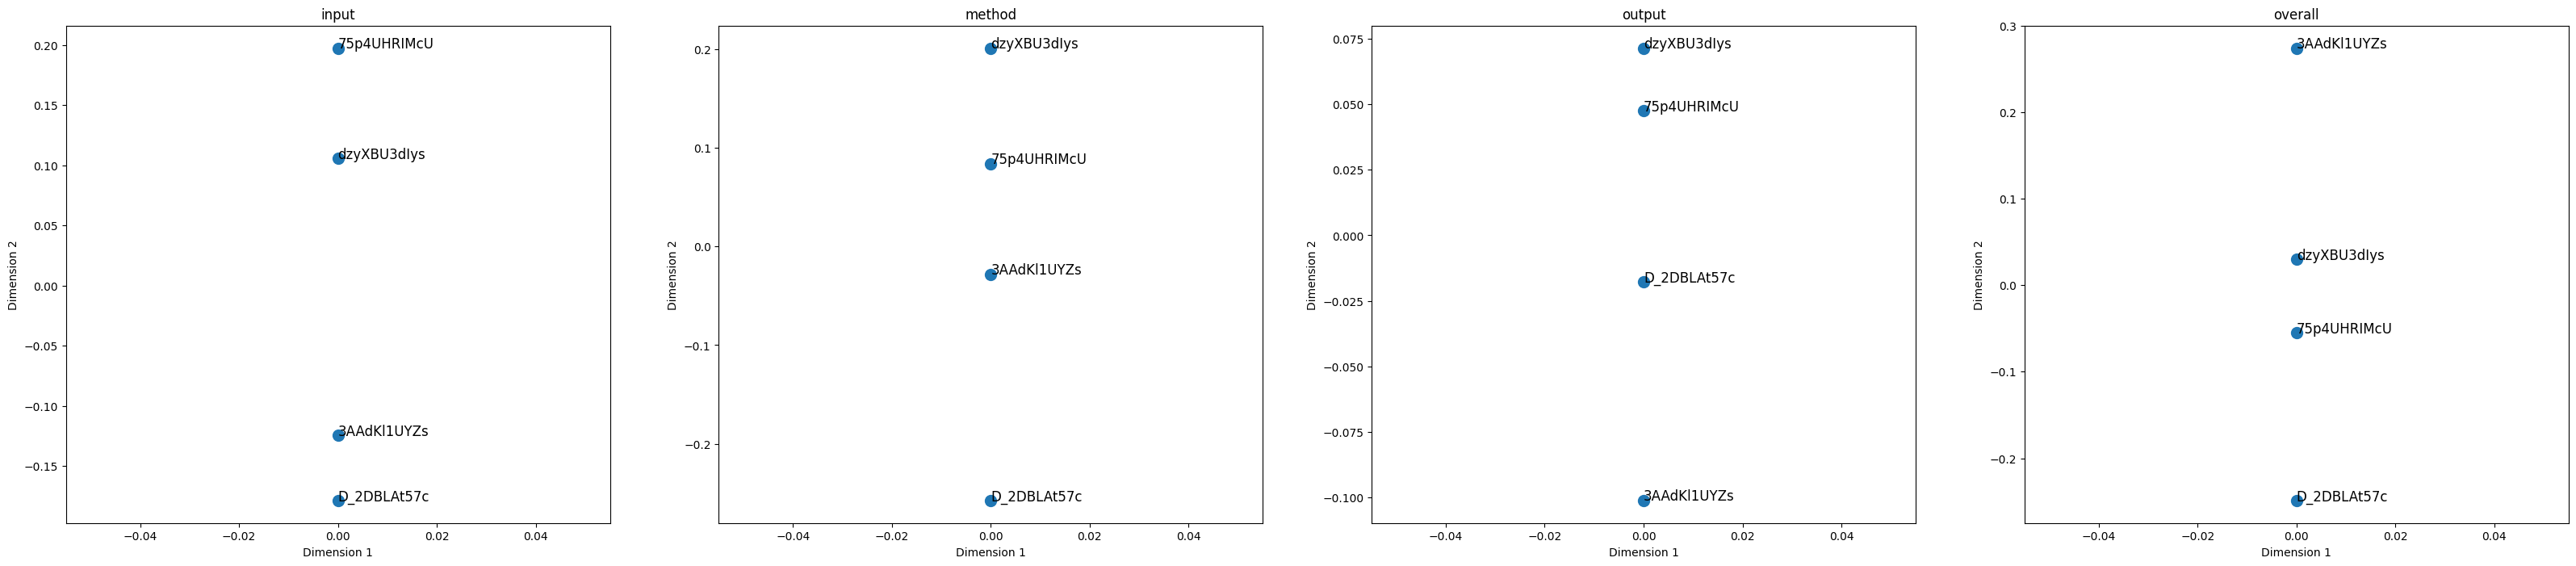

In [109]:
def scatter_plot_2D(ax, points, labels):
    
    ### Plot the coordinates
    ax.scatter(points[:, 0], points[:, 1], s=100)
    for i, label in enumerate(labels):
        ax.text(points[i, 0], points[i, 1], label, fontsize=12)
    ax.set_title('MDS Visualization of Distance Matrix')

def matrix_to_points(matrix, dims):
    sym_matrix = (matrix + matrix.T) / 2

    ### Transform distance matrix to coordinates
    from sklearn.manifold import MDS

    embedding = MDS(n_components=dims, dissimilarity='precomputed', random_state=42)
    X_transformed = embedding.fit_transform(sym_matrix)
    print(embedding.stress_)
    
    if dims == 1:
        ## add a second dimension and set it to 0
        X_transformed = np.concatenate([np.zeros((X_transformed.shape[0], 1)), X_transformed], axis=1)
    return X_transformed

fig, axs = plt.subplots(1, len(distances_per_group), figsize=(10 * len(distances_per_group), 8))
for idx, (group, distance_matrices) in enumerate(distances_per_group.items()):
    labels = [*video_id_to_index.keys()]
    points = matrix_to_points(distance_matrices['video-level'], 1)
    scatter_plot_2D(axs[idx], points, labels)
    axs[idx].set_title(f'{group}')
    axs[idx].set_xlabel('Dimension 1')
    axs[idx].set_ylabel('Dimension 2')
plt.show()


In [ ]:
"""
Output alignments from each approach side-by-side for each comparison
"""
for key, comparisons in pair_comparisons.items():
    print("##", key)
    print()
    approaches = [*comparisons.keys()]
    print("|", end="")
    for approach in approaches:
        print(approach, "|", end="")
    print()
    print("|", end="")
    for approach in approaches:
        print("---|", end="")
    print()
    max_alignments = max([len(comparisons[approach]) for approach in approaches if approach in comparisons])
    for i in range(max_alignments):
        print("|", end="")
        for approach in approaches:
            if approach in comparisons:
                if i < len(comparisons[approach]):
                    alignment = comparisons[approach][i]
                    alignment_str = "- ({subgoal_title}) **{relation}** **{aspect}**: {alignment_description}".format(**alignment)
                    print(alignment_str, "|", end="")
                else:
                    print(" |", end="")
            else:
                print(" |", end="")
        print()
    print()
    print()

## 75p4UHRIMcU-dzyXBU3dIys

|approach_1 |
|---|
|- (Prepare Ingredients) **alternative** **materials**: Uses bacon instead of guanciale, which is traditional for carbonara. |
|- (Prepare Ingredients) **alternative** **materials**: Uses only egg yolks instead of a mix of whole eggs and yolks. |
|- (Prepare Ingredients) **alternative** **explanations**: Emphasizes that the recipe is not traditional carbonara. |
|- (Prepare Ingredients) **alternative** **tips**: Provides a trick for separating egg yolks using your thumb. |
|- (Prepare Ingredients) **alternative** **tips**: Suggests using hand gesture muscles for easier cheese grating. |
|- (Prepare Ingredients) **alternative** **warnings**: Warns against accidentally using egg yolks if not intended. |
|- (Prepare Egg Mixture) **alternative** **materials**: Mentions using egg yolks and whole eggs without specifying the number. |
|- (Create Sauce) **alternative** **materials**: The sauce uses only egg yolks instead of whole eggs. |
|- (Crea